In [3]:
# @title
import pandas as pd
from scipy import stats
import numpy as np
import math

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from itertools import product
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.transforms
from torchvision.transforms import ToTensor
from torchvision.ops import MLP
from torch import optim

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from IPython.display import clear_output

!pip install optuna
import optuna as opt

In [11]:
train_df = pd.read_csv('database/train.csv', index_col=0)
test_df = pd.read_csv('database/test.csv', index_col=0)
train_df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


# Train Validation Split

In [12]:
original_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

In [14]:
train_df, validation_df = train_test_split(original_df,test_size= 0.25, stratify=original_df['satisfaction'])

print('original_df: ',len(original_df))
print('train_df size: ', len(train_df), "| validation_df size:", len(validation_df))
print(f'train_df: {len(train_df)/len(original_df)}%', f"| validation_df: {len(validation_df)/len(original_df)}%",)

original_df:  103904
train_df size:  77928 | validation_df size: 25976
train_df: 0.75% | validation_df: 0.25%


# Outliers

<Axes: >

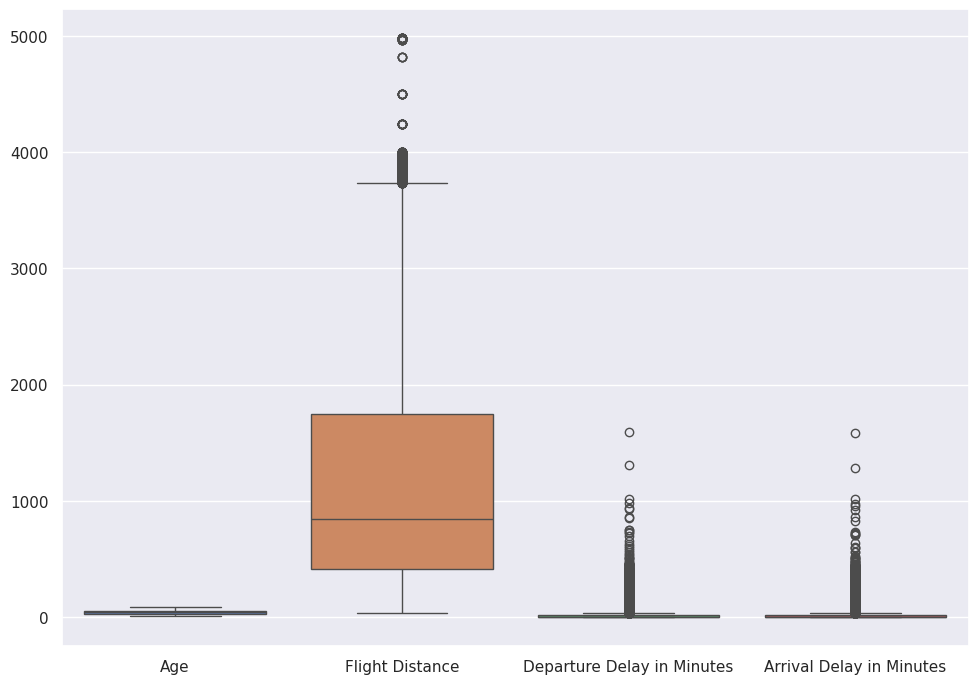

In [15]:
train_df.reset_index(drop=True, inplace=True)

cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

sns.boxplot(data=train_df[cols])

Original DataFrame Shape: (77928, 23)
DataFrame Shape after Removing Outliers: (76209, 23)
Columns with z-score > 3:  ['Age', 'Flight Distance', 'Departure Delay in Minutes']


<Axes: >

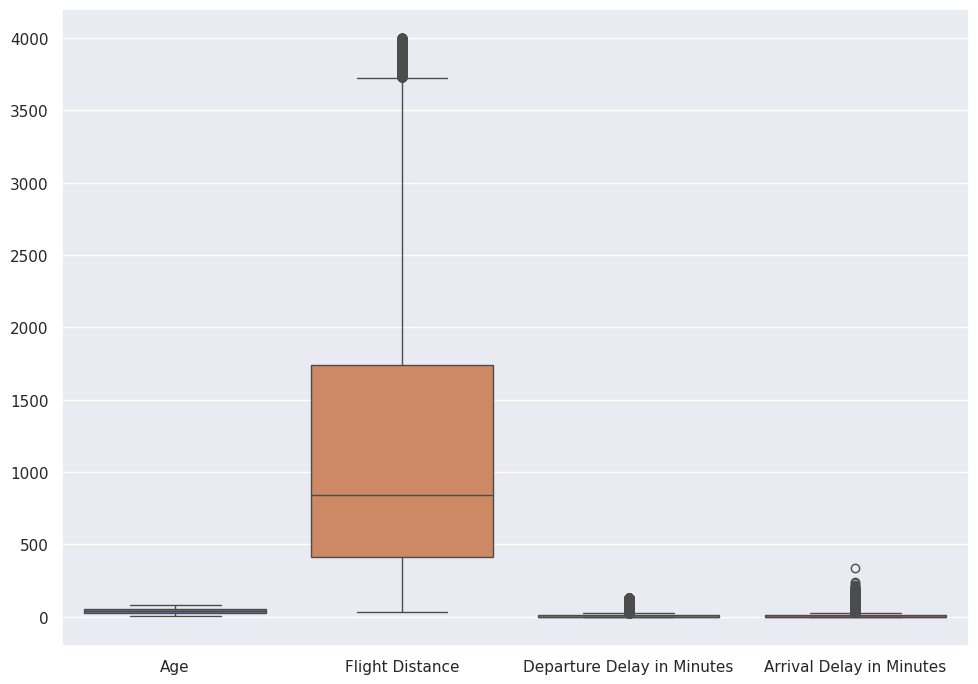

In [16]:
print("Original DataFrame Shape:", train_df.shape)
z_score_col = []
for cl in cols:
    z = np.abs(stats.zscore(train_df[cl]))
    outlier_set = (np.where(z > 3)[0])
    train_df = train_df.drop(index=outlier_set)
    train_df.reset_index(drop=True, inplace=True)
    if len(outlier_set > 0):
        z_score_col.append(cl)


print("DataFrame Shape after Removing Outliers:", train_df.shape)
print('Columns with z-score > 3: ', z_score_col)

sns.boxplot(data=train_df[cols])

# Enconding

## Class Variable

In [17]:
classes_dict = {
    'neutral or dissatisfied': 0,
    'satisfied': 1
}
def ord_encode(x):
    return classes_dict[x]

dec_class = 'satisfaction'
print('Before Encoding: ', train_df[dec_class].values)
train_df[dec_class] = train_df[dec_class].map(ord_encode)
validation_df[dec_class] = validation_df[dec_class].map(ord_encode)
print('After Encoding: ', train_df[dec_class].values)


Before Encoding:  ['satisfied' 'satisfied' 'neutral or dissatisfied' ... 'satisfied'
 'neutral or dissatisfied' 'neutral or dissatisfied']
After Encoding:  [1 1 0 ... 1 0 0]


## One Hot Enconding

In [18]:
one_hot_encoder_vars = ['Type of Travel', 'Gender', 'Customer Type']
validation_df = pd.get_dummies(validation_df, columns=one_hot_encoder_vars, drop_first=True)
train_df = pd.get_dummies(train_df, columns=one_hot_encoder_vars, drop_first=True)
train_df[['Type of Travel_Personal Travel', 'Gender_Male',  'Customer Type_disloyal Customer']]

,Type of Travel_Personal Travel,Gender_Male,Customer Type_disloyal Customer
0,False,False,False
1,False,True,False
2,False,True,False
3,False,True,False
4,False,True,False
...,...,...,...
76204,False,True,False
76205,True,False,False
76206,False,True,False
76207,False,False,True


## Ordinal Enconding

In [19]:
classes_dict = {
    'Eco': 0,
    'Eco Plus': 1,
    'Business': 2
}
def ord_encode(x):
    return classes_dict[x]

ordinal_encoder_vars = ['Class']
print('Before Encoding: ', train_df[ordinal_encoder_vars].values)
train_df[ordinal_encoder_vars] = train_df[ordinal_encoder_vars].applymap(ord_encode)
validation_df[ordinal_encoder_vars] = validation_df[ordinal_encoder_vars].applymap(ord_encode)
print('After Encoding: ', train_df[ordinal_encoder_vars].values)

Before Encoding:  [['Business']
 ['Business']
 ['Business']
 ...
 ['Business']
 ['Eco']
 ['Eco']]
After Encoding:  [[2]
 [2]
 [2]
 ...
 [2]
 [0]
 [0]]


# Correlation

## Continuous Variables

Needs to be done before Binning

<Axes: >

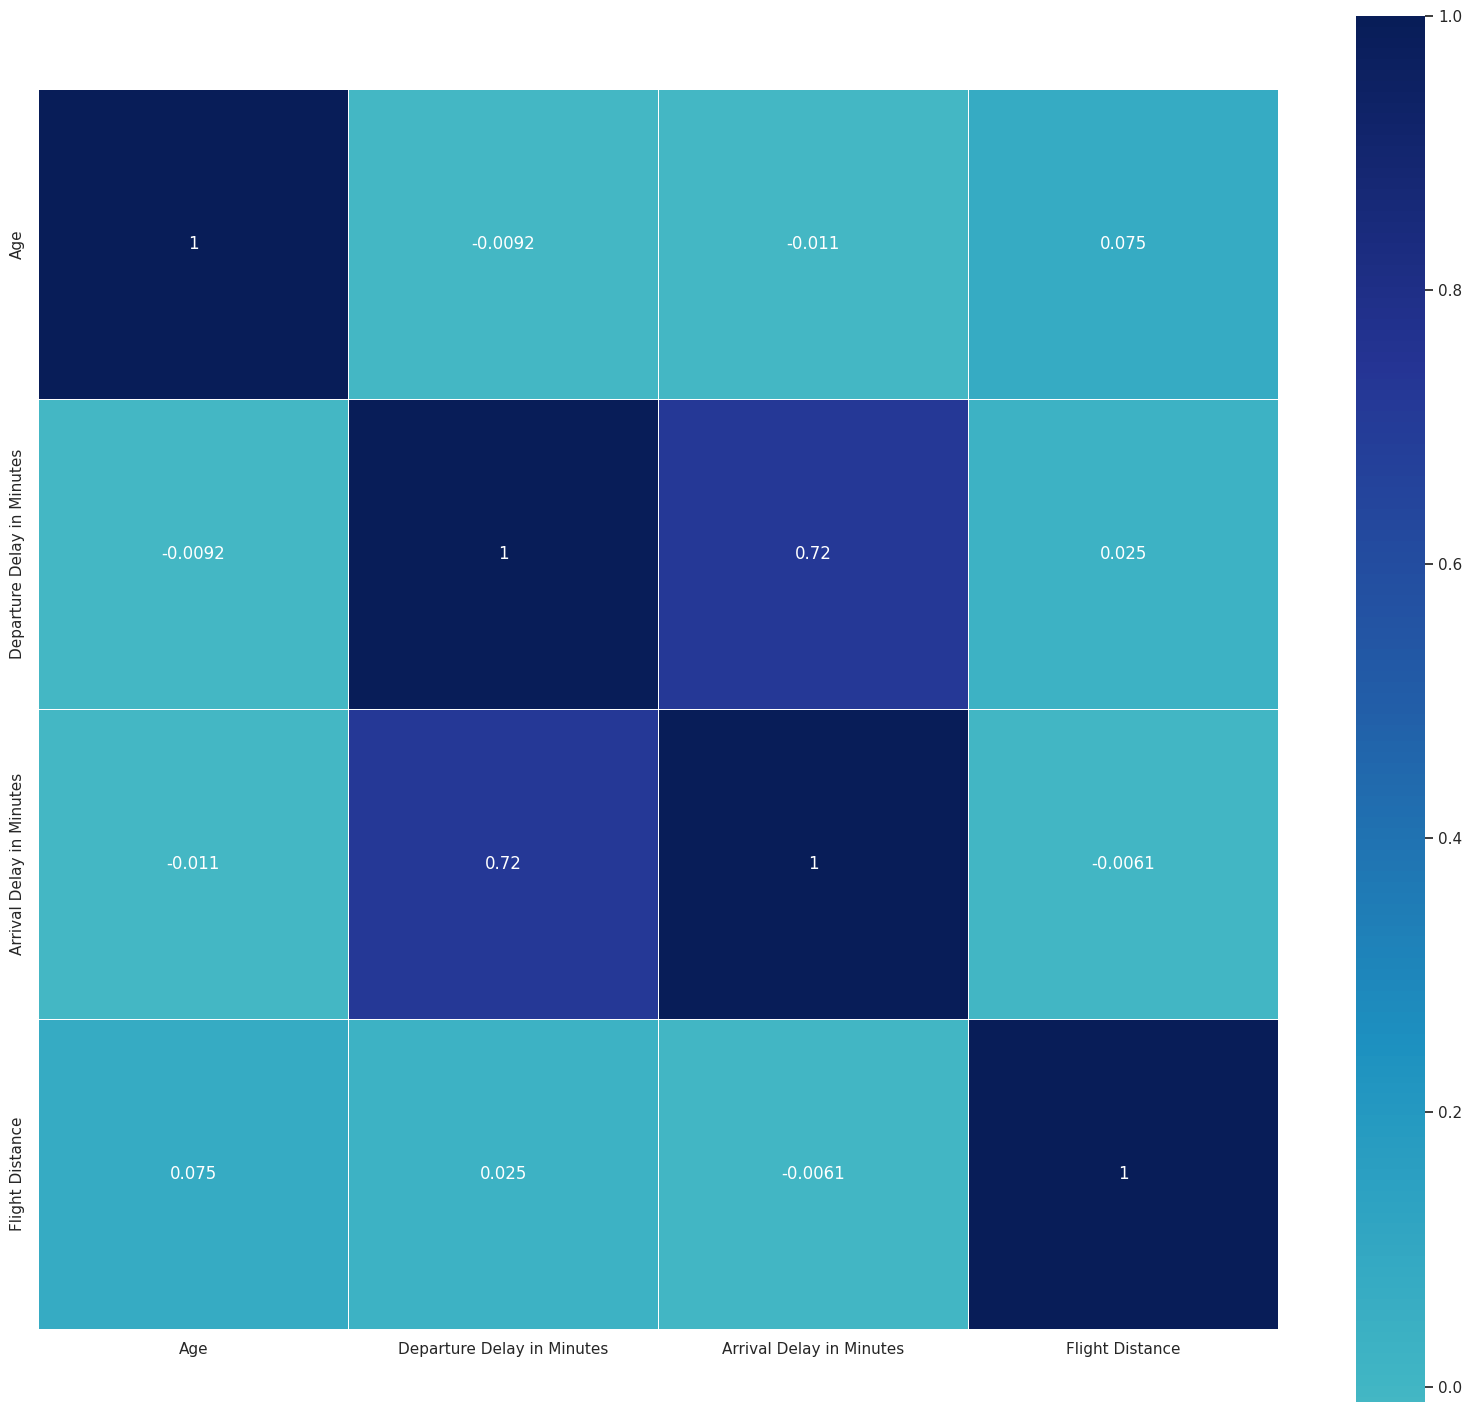

In [20]:
columns = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']

corr = train_df[columns].corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, cmap="YlGnBu", center=0,
           square=True, linewidths=.5)

In [21]:
corr

,Age,Departure Delay in Minutes,Arrival Delay in Minutes,Flight Distance
Age,1.000000,-0.009160,-0.011266,0.074638
Departure Delay in Minutes,-0.009160,1.000000,0.719864,0.024828
Arrival Delay in Minutes,-0.011266,0.719864,1.000000,-0.006147
Flight Distance,0.074638,0.024828,-0.006147,1.000000


## Categorical Variables (Chi Squared Test)

In [22]:
columns = ['Class', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'satisfaction', 'Type of Travel_Personal Travel', 'Gender_Male',
       'Customer Type_disloyal Customer']

print('Shape Before dropna: ', train_df[columns].shape)
df_corr = train_df[columns].dropna()
print('Shape After dropna: ', df_corr.shape)

cat_var_prod = list(product(columns,columns, repeat = 1))

result = []
for i in cat_var_prod:
       if i[0] != i[1]:
              result.append((i[0],i[1],list(stats.chi2_contingency(pd.crosstab(df_corr[i[0]], df_corr[i[1]])))[1]))
result

Shape Before dropna:  (76209, 19)
Shape After dropna:  (76209, 19)


[('Class', 'Inflight wifi service', 0.0),
 ('Class', 'Departure/Arrival time convenient', 0.0),
 ('Class', 'Ease of Online booking', 0.0),
 ('Class', 'Gate location', 0.0),
 ('Class', 'Food and drink', 2.320979059899834e-167),
 ('Class', 'Online boarding', 0.0),
 ('Class', 'Seat comfort', 0.0),
 ('Class', 'Inflight entertainment', 0.0),
 ('Class', 'On-board service', 0.0),
 ('Class', 'Leg room service', 0.0),
 ('Class', 'Baggage handling', 0.0),
 ('Class', 'Checkin service', 0.0),
 ('Class', 'Inflight service', 0.0),
 ('Class', 'Cleanliness', 0.0),
 ('Class', 'satisfaction', 0.0),
 ('Class', 'Type of Travel_Personal Travel', 0.0),
 ('Class', 'Gender_Male', 0.010761894622339735),
 ('Class', 'Customer Type_disloyal Customer', 1.8310621370702467e-252),
 ('Inflight wifi service', 'Class', 0.0),
 ('Inflight wifi service', 'Departure/Arrival time convenient', 0.0),
 ('Inflight wifi service', 'Ease of Online booking', 0.0),
 ('Inflight wifi service', 'Gate location', 0.0),
 ('Inflight wifi se

<Axes: >

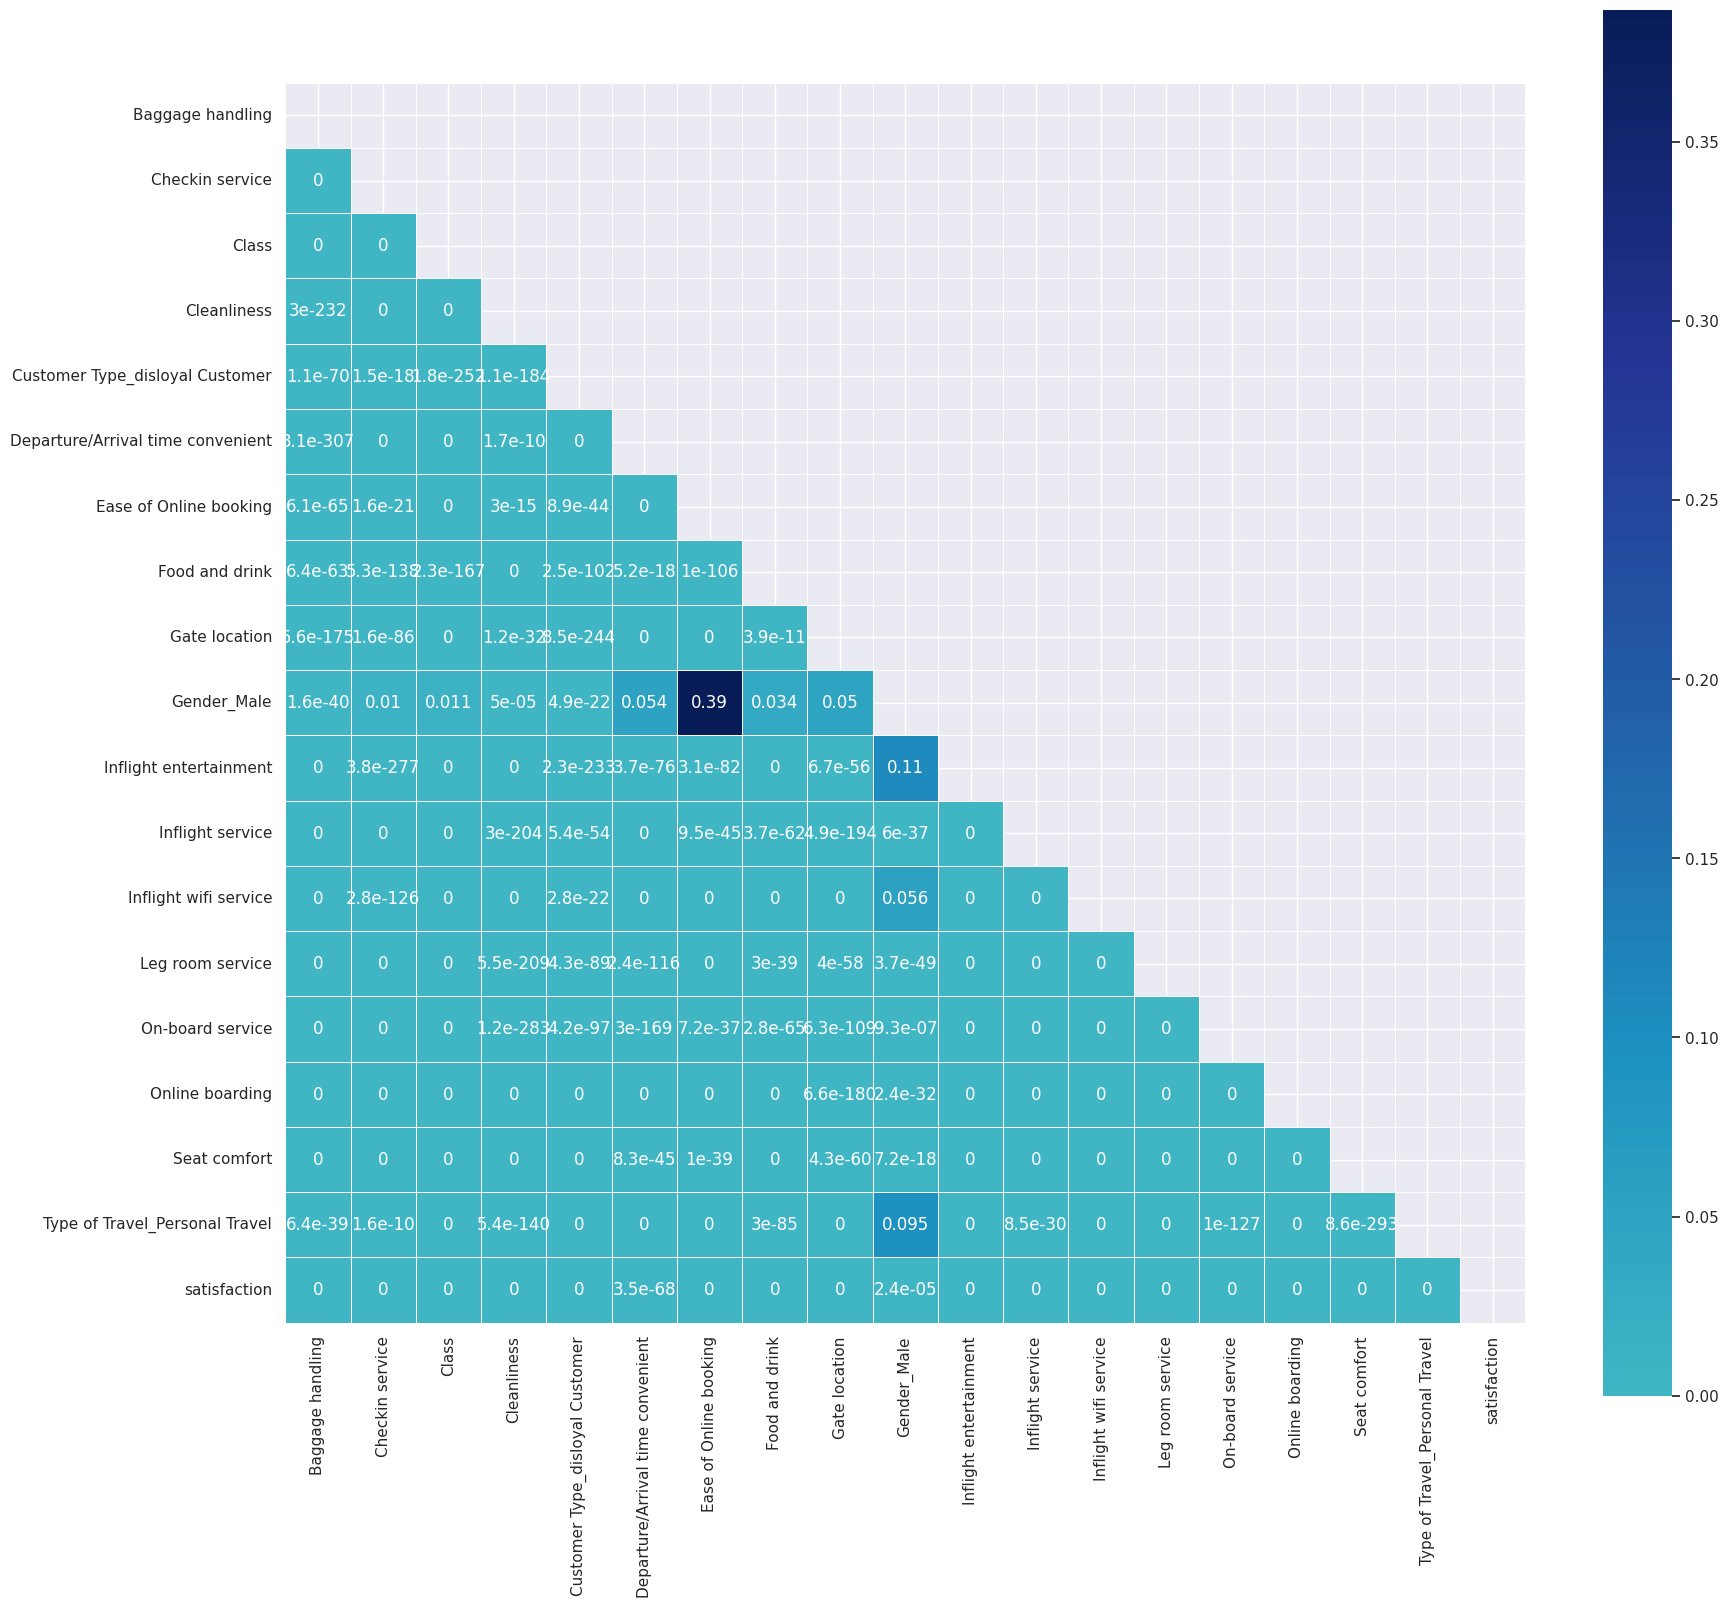

In [23]:
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2',
                                                       'corr'])

chi_test_output = chi_test_output.pivot(index='var1', columns='var2', values='corr')
chi_test_output =  chi_test_output.rename_axis(None, axis=1)
chi_test_output =  chi_test_output.rename_axis(None, axis=0)

# Generate a mask for the upper triangle
mask = np.zeros_like(chi_test_output, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(chi_test_output, annot = True, mask=mask, cmap="YlGnBu", center=0,
           square=True, linewidths=.5)


# Binning

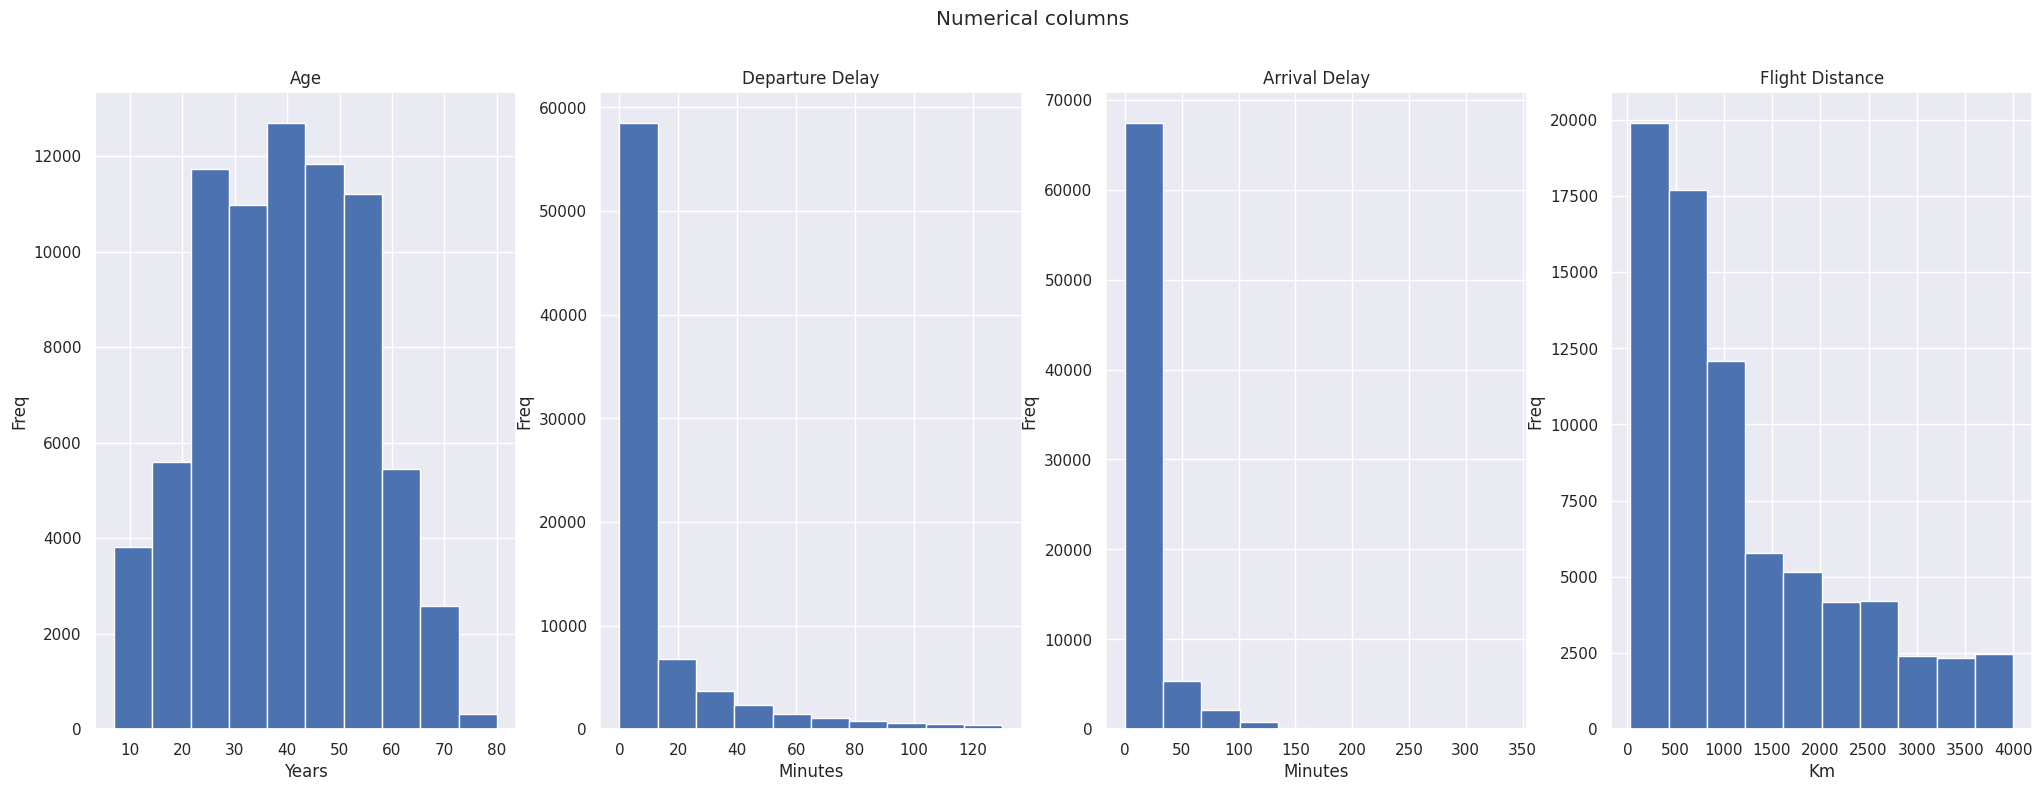

In [24]:
binning_vars = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

fig.set_figwidth(25)
fig.suptitle('Numerical columns')

ax1.set_title('Age')
ax1.set(xlabel='Years', ylabel='Freq')
ax1.hist(train_df['Age'])

ax2.set_title('Departure Delay')
ax2.set(xlabel='Minutes', ylabel='Freq')
ax2.hist(train_df['Departure Delay in Minutes'])

ax3.set_title('Arrival Delay')
ax3.set(xlabel='Minutes', ylabel='Freq')
ax3.hist(train_df['Arrival Delay in Minutes'])

ax4.set_title('Flight Distance')
ax4.set(xlabel='Km', ylabel='Freq')
ax4.hist(train_df['Flight Distance'])

plt.show()

In [25]:
def dist_binning(column: str):
    # 4 bins
    boundary = math.ceil((train_df[column].max()- train_df[column].min())/4)

    print(f'{column} boundary to split: ', boundary)

    bins_means = [math.ceil(train_df[(train_df[column] >= boundary*i) & (train_df[column] < boundary*(i+1))][column].mean()) for i in range(4)]
    print('Bin means: ', bins_means)

    def binnign_method(age) -> int:

        if np.isnan(age):
            return np.nan

        if age < boundary:
            return bins_means[0]

        if age < 2*boundary:
            return bins_means[1]

        if age < 3*boundary:
            return bins_means[2]

        if age < 4*boundary:
            return bins_means[3]

    print(f'{column} before binning: ', train_df[column].head(10))
    train_df[column] = train_df[column].map(binnign_method)
    validation_df[column] = validation_df[column].map(binnign_method)
    print(f'{column} After binning: ', train_df[column].head(10))


### Age

In [26]:
dist_binning(column='Age')

Age boundary to split:  19
Bin means:  [14, 29, 47, 63]
Age before binning:  0    72
1    47
2    51
3    29
4    42
5    54
6    43
7    66
8    26
9    62
Name: Age, dtype: int64
Age After binning:  0    63.0
1    47.0
2    47.0
3    29.0
4    47.0
5    47.0
6    47.0
7    63.0
8    29.0
9    63.0
Name: Age, dtype: float64


### Departure Delay

In [27]:
dist_binning(column='Departure Delay in Minutes')

Departure Delay in Minutes boundary to split:  33
Bin means:  [4, 47, 80, 113]
Departure Delay in Minutes before binning:  0     2
1    18
2     0
3     0
4    31
5     4
6     0
7     0
8    27
9     0
Name: Departure Delay in Minutes, dtype: int64
Departure Delay in Minutes After binning:  0    4
1    4
2    4
3    4
4    4
5    4
6    4
7    4
8    4
9    4
Name: Departure Delay in Minutes, dtype: int64


### Arrival Delay

In [28]:
dist_binning(column='Arrival Delay in Minutes')

Arrival Delay in Minutes boundary to split:  85
Bin means:  [9, 107, 189, 337]
Arrival Delay in Minutes before binning:  0     9.0
1    14.0
2     0.0
3     0.0
4    45.0
5    28.0
6     0.0
7     0.0
8    16.0
9     0.0
Name: Arrival Delay in Minutes, dtype: float64
Arrival Delay in Minutes After binning:  0    9.0
1    9.0
2    9.0
3    9.0
4    9.0
5    9.0
6    9.0
7    9.0
8    9.0
9    9.0
Name: Arrival Delay in Minutes, dtype: float64


### Flight Distance

In [29]:
dist_binning(column='Flight Distance')

Flight Distance boundary to split:  993
Bin means:  [497, 1424, 2443, 3483]
Flight Distance before binning:  0    2072
1    1562
2    3464
3    1747
4    2614
5    1719
6     733
7     425
8     591
9     632
Name: Flight Distance, dtype: int64
Flight Distance After binning:  0    2443.0
1    1424.0
2    3483.0
3    1424.0
4    2443.0
5    1424.0
6     497.0
7     497.0
8     497.0
9     497.0
Name: Flight Distance, dtype: float64


In [30]:
train_df.describe()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,76007.000000,76209.000000,76030.000000,76209.000000,76209.000000,76209.000000,76209.000000,76209.000000,76209.000000,76209.000000,76209.000000,76209.000000,76209.000000,76209.000000,76209.000000,76209.000000,76209.000000,76209.000000,76007.000000,76209.000000
mean,39.967556,1.028960,1181.591069,2.730137,3.056896,2.754438,2.972484,3.207902,3.255324,3.442349,3.358698,3.384745,3.342991,3.627734,3.305751,3.648217,3.286961,10.778963,11.470562,0.434922
std,14.038505,0.962824,950.344616,1.326679,1.526909,1.397246,1.277764,1.327371,1.348740,1.318797,1.333854,1.288036,1.320719,1.183558,1.263925,1.171821,1.311336,20.468019,15.595554,0.495750
min,14.000000,0.000000,497.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4.000000,9.000000,0.000000
25%,29.000000,0.000000,497.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,4.000000,9.000000,0.000000
50%,47.000000,1.000000,497.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,4.000000,9.000000,0.000000
75%,47.000000,2.000000,1424.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,4.000000,9.000000,1.000000
max,63.000000,2.000000,3483.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,113.000000,337.000000,1.000000


# Missing Values

In [31]:
# sns.heatmap(train_df.isnull(), cbar=False)
print(train_df.columns[train_df.isnull().any()])
columns = train_df.columns[train_df.isnull().any()]
train_df[columns] = train_df[columns].fillna(train_df[columns].median())
print(train_df.columns[train_df.isnull().any()])

Index(['Age', 'Flight Distance', 'Arrival Delay in Minutes'], dtype='object')
Index([], dtype='object')


In [32]:
# sns.heatmap(validation_df.isnull(), cbar=False)
print(validation_df.columns[validation_df.isnull().any()])
columns = validation_df.columns[validation_df.isnull().any()]

#substituindo pela mediana do conjunto de teste
validation_df[columns] = validation_df[columns].fillna(train_df[columns].median())
validation_df.columns[validation_df.isnull().any()]

Index(['Age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes'],
      dtype='object')


Index([], dtype='object')

# Min Max Scaling

In [33]:
columns = ['Age', 'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

scaler = MinMaxScaler()
f_scaler=scaler.fit(train_df[columns])

# Train
train_df[columns] = f_scaler.transform(train_df[columns])

# Validation
validation_df[columns] = f_scaler.transform(validation_df[columns])

# OverSampling

In [34]:
def overSampling(x, y):
  ros = RandomOverSampler(
    sampling_strategy='auto',
    random_state=0,
  )
  return ros.fit_resample(x,y)

def printClassDistributionRate(y):
  print('total: ',len(y))
  print('satisfied: ', len(y[y['satisfaction'] == 1]), ' not satisfied: ', len(y[y['satisfaction'] != 1]))
  print('satisfied: {:.2f}%'.format(len(y[y['satisfaction'] == 1])/len(y) * 100), ' not satisfied: {:.2f}%'.format(len(y[y['satisfaction'] != 1])/len(y) * 100), '\n')

In [35]:
x_train_df = train_df.drop(columns='satisfaction')
y_train_df = train_df[['satisfaction']]

printClassDistributionRate(y_train_df)

x_train_df, y_train_df = overSampling(x_train_df, y_train_df )

printClassDistributionRate(y_train_df)

total:  76209
satisfied:  33145  not satisfied:  43064
satisfied: 43.49%  not satisfied: 56.51% 

total:  86128
satisfied:  43064  not satisfied:  43064
satisfied: 50.00%  not satisfied: 50.00% 



In [36]:
x_validation_df = validation_df.drop(columns='satisfaction')
y_validation_df = validation_df[['satisfaction']]

printClassDistributionRate(y_validation_df)

x_validation_df, y_validation_df = overSampling(x_validation_df, y_validation_df )

printClassDistributionRate(y_validation_df)

total:  25976
satisfied:  11256  not satisfied:  14720
satisfied: 43.33%  not satisfied: 56.67% 

total:  29440
satisfied:  14720  not satisfied:  14720
satisfied: 50.00%  not satisfied: 50.00% 



# Experimento com Modelos

In [37]:
X_train, _, y_train, _ = train_test_split(x_train_df, y_train_df, test_size=0.90, stratify=y_train_df['satisfaction'])
X_valid, _, y_valid, _ = train_test_split(x_validation_df, y_validation_df, test_size=0.50, stratify=y_validation_df['satisfaction'])


# X_train, y_train = x_train_df, y_train_df
# X_valid, y_valid = x_validation_df, y_validation_df

X_train.shape, y_train.shape

((8612, 22), (8612, 1))

In [38]:
def plot_confusion(y_true, y_pred, title):
 disp = ConfusionMatrixDisplay.from_predictions(
 y_true,
 y_pred,
 cmap=plt.cm.Blues,
 normalize=None,
 )
 disp.ax_.set_title(title)
 plt.show()

In [39]:
BATCH_SIZE = 128
EPOCHS = 20000

## MLP - Keras

In [ ]:
class MPL():
  def __init__(self, in_shape, out_shape, hidden_layers, activation, dropout, optmizer, lr, regularization, patience) -> None:
    self.model = Sequential()

    self.model.add(keras.Input(shape=in_shape))
    for layer in hidden_layers:
      self.model.add(Dense(layer, activation=activation, activity_regularizer=regularizers.L2(regularization)))
      self.model.add(Dropout(dropout))


    self.model.add(Dense(out_shape, activation=activation))

    self.model.summary()

    self.early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)

    self.opt = optmizer(learning_rate=lr)

  def __del__(self):
    del self.model

  def train(self, X_train, y_train, X_validation, y_validation, batch_size, epochs):
    self.model.compile(loss="sparse_categorical_crossentropy", optimizer=self.opt, metrics=['accuracy'])
    return self.model.fit(X_train, y_train, validation_data = (X_validation, y_validation), batch_size = batch_size, epochs = epochs, shuffle = True, callbacks=[self.early_stop_callback], verbose=0)

  def evaluate(self, X, y):
    loss, accuracy = self.model.evaluate(X, y)
    print('Loss:', loss)
    print('Accuracy:', accuracy)
    return loss, accuracy

  def predict(self, x):
    return self.model.predict(x)

In [ ]:
def plot_train_history(history):
  pd.DataFrame(history.history).plot()
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

PARAMETROS: F.Act.: sigmoid; Layers: [10, 5]; LR: 0.1; Dropout: 0; Reg: 0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

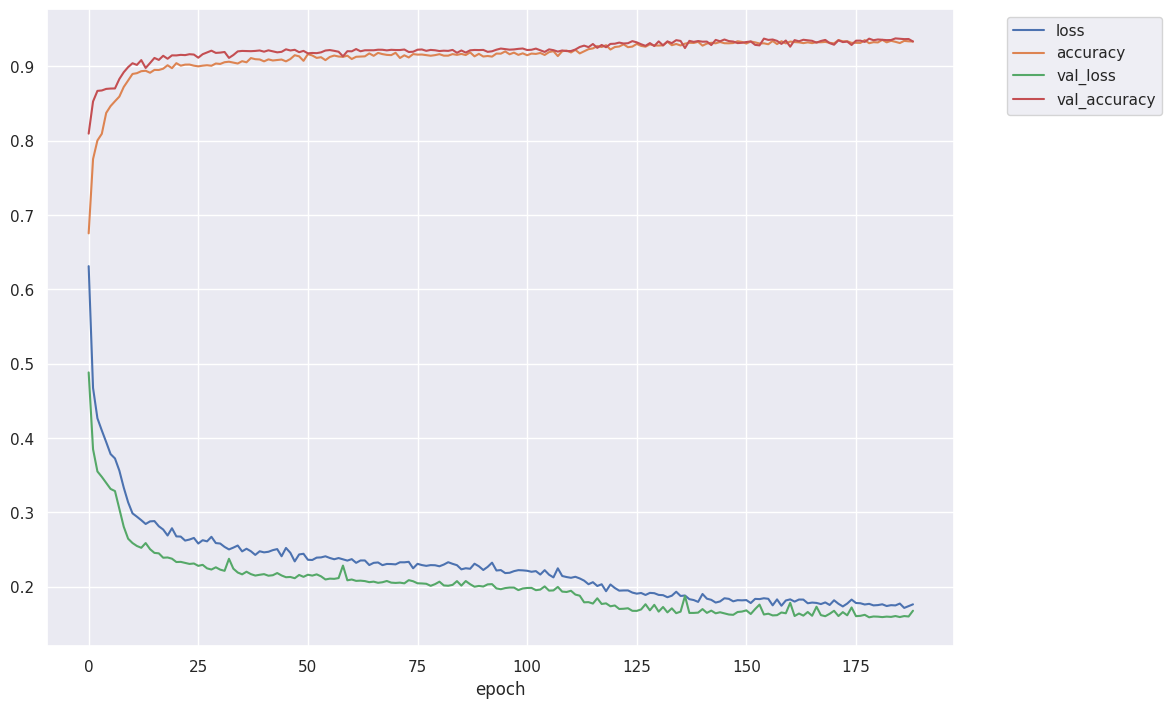

In [ ]:
def grid_search(X_t, y_t, X_v, y_v, activation_fn, hidden_layers, learning_rate, dropout, regularization):
  best_acc = 0
  best_model = None
  best_hist = None
  args = None

  for act in activation_fn:
    for hl in hidden_layers:
      for lr in learning_rate:
        for drp in dropout:
          for reg in regularization:
            print(f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}')
            tf.keras.backend.clear_session()
            model = MPL(in_shape=(22,), out_shape=2, hidden_layers=hl, activation=act, dropout=drp, optmizer=optimizers.Adam, lr=lr, regularization=reg, patience=10)
            history = model.train(X_t, y_t, X_v, y_v, batch_size=BATCH_SIZE, epochs=EPOCHS)
            loss, acc = model.evaluate(X_v, y_v)
            if acc > best_acc:
                best_acc = acc
                best_model = model
                best_hist = history
                args = f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}'
            print(f'SCORES: acc: {acc}, loss: {loss}\n')
            del model
            del history
  print(f"\n\nBest model args: {args}")
  return best_model, best_hist

X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32')
X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32')

hidden_channels = [[10, 5], [5, 10]]
actv_fns = ['sigmoid', 'relu', 'tanh','softmax']
learning_rates = [0.1, 0.01]
dropout = [0, 0.1]
regularization = [0, 0.01]

# softmax; Layers: [10, 5]; LR: 0.01; Dropout: 0; Reg: 0.01

# hidden_channels = [[10, 5]]
# actv_fns = ['softmax']
# learning_rates = [0.01]
# dropout = [0]
# regularization = [0.01]

best_model, best_hist = grid_search(X_t, y_t, X_v, y_v, actv_fns, hidden_channels, learning_rates, dropout, regularization)
plot_train_history(best_hist)

In [ ]:
best_model.evaluate(X_v, y_v)

460/460 [==============================] - 1s 2ms/step - loss: 0.1589 - accuracy: 0.9374
Loss: 0.15887874364852905
Accuracy: 0.9373641014099121


(0.15887874364852905, 0.9373641014099121)

In [ ]:
# X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32')
# X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32')

# tf.keras.backend.clear_session()
# history = best_model.train(X_t, y_t, X_v, y_v, batch_size=BATCH_SIZE, epochs=EPOCHS)

In [ ]:
# plot_train_history(history)

In [ ]:
# best_model.evaluate(X_v, y_v)

In [ ]:
# y_pred = best_model.predict(X_v)
# y_pred
# plot_confusion(y_v, y_pred, 'Best Model')

## MLP - Keras c/ Optuna

In [40]:
class MPL():
  def __init__(self, in_shape, out_shape, hidden_layers, activation, dropout, optmizer, lr, regularization, patience) -> None:
    self.model = Sequential()

    self.model.add(keras.Input(shape=in_shape))
    for layer in hidden_layers:
      self.model.add(Dense(layer, activation=activation, activity_regularizer=regularizers.L2(regularization)))
      self.model.add(Dropout(dropout))


    self.model.add(Dense(out_shape, activation=activation))

    self.model.summary()

    self.early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)

    self.opt = optmizer(learning_rate=lr)

  def __del__(self):
    del self.model

  def train(self, X_train, y_train, X_validation, y_validation, batch_size, epochs):
    self.model.compile(loss="sparse_categorical_crossentropy", optimizer=self.opt, metrics=['accuracy'])
    return self.model.fit(X_train, y_train, validation_data = (X_validation, y_validation), batch_size = batch_size, epochs = epochs, shuffle = True, callbacks=[self.early_stop_callback], verbose=0)

  def evaluate(self, X, y):
    loss, accuracy = self.model.evaluate(X, y)
    print('Loss:', loss)
    print('Accuracy:', accuracy)
    return loss, accuracy

  def predict(self, x):
    return self.model.predict(x)

In [41]:
def plot_train_history(history):
  pd.DataFrame(history.history).plot()
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

In [ ]:
def objective(trial):

  hidden_channels = [[10, 5], [5, 10]]
  actv_fns = ['sigmoid', 'relu', 'tanh','softmax']
  learning_rates = [1e-2, 1e-1]
  dropout = [0, 0.1]
  regularization = [0, 1e-2]

  # softmax; Layers: [10, 5]; LR: 0.01; Dropout: 0; Reg: 0.01

  # hidden_channels = [[10, 5]]
  # actv_fns = ['softmax']
  # learning_rates = [0.01]
  # dropout = [0]
  # regularization = [0.01]

  hl = trial.suggest_categorical('Hidden Channels', hidden_channels)
  act = trial.suggest_categorical('Activation Function', actv_fns)
  lr = trial.suggest_categorical('Learning rate', learning_rates)
  drp = trial.suggest_categorical('Dropout', dropout)
  reg = trial.suggest_categorical('Regularization', regularization)

  X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32')
  X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32')

  tf.keras.backend.clear_session()
  model = MPL(in_shape=(22,), out_shape=2, hidden_layers=hl, activation=act, dropout=drp, optmizer=optimizers.Adam, lr=lr, regularization=reg, patience=10)
  history = model.train(X_t, y_t, X_v, y_v, batch_size=BATCH_SIZE, epochs=EPOCHS)
  loss, acc = model.evaluate(X_v, y_v)

  return loss

study = opt.create_study(direction = 'minimize')
study.optimize(objective, n_trials=10)

# best_model, best_hist = grid_search(X_t, y_t, X_v, y_v, actv_fns, hidden_channels, learning_rates, dropout, regularization)
# plot_train_history(best_hist)

[I 2024-07-06 12:46:23,318] A new study created in memory with name: no-name-b25ef786-4523-4067-8a32-f8029e2d07c8


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
460/460 [=========

[I 2024-07-06 12:47:49,284] Trial 0 finished with value: 0.46170973777770996 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'tanh', 'Learning rate': 0.0004218971099052479, 'Dropout': 0.07935769635551343, 'Regularization': 0.0013324151197423517}. Best is trial 0 with value: 0.46170973777770996.


Loss: 0.46170973777770996
Accuracy: 0.8117527365684509
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________

[I 2024-07-06 12:48:05,211] Trial 1 finished with value: 0.34808674454689026 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'relu', 'Learning rate': 0.0017496952352562386, 'Dropout': 0.021953753334657412, 'Regularization': 0.007518295410398559}. Best is trial 1 with value: 0.34808674454689026.


Loss: 0.34808674454689026
Accuracy: 0.859646737575531
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________________

[I 2024-07-06 13:21:03,514] Trial 2 finished with value: 0.2931603491306305 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'softmax', 'Learning rate': 2.7789429742432298e-05, 'Dropout': 0.022014486620771323, 'Regularization': 0.004306296365695329}. Best is trial 2 with value: 0.2931603491306305.


Loss: 0.2931603491306305
Accuracy: 0.8843070864677429
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________________

[I 2024-07-06 13:21:12,414] Trial 3 finished with value: 0.7123004794120789 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'tanh', 'Learning rate': 0.05491076873580257, 'Dropout': 0.031232952802417502, 'Regularization': 0.0022441908955077926}. Best is trial 2 with value: 0.2931603491306305.


Loss: 0.7123004794120789
Accuracy: 0.48947009444236755
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_____________________________

[I 2024-07-06 14:05:36,316] Trial 4 finished with value: 0.2197997123003006 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'softmax', 'Learning rate': 8.969361872464005e-05, 'Dropout': 0.03525883301669389, 'Regularization': 0.0009103817064256847}. Best is trial 4 with value: 0.2197997123003006.


Loss: 0.2197997123003006
Accuracy: 0.9088994860649109
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________________

[I 2024-07-06 14:07:00,309] Trial 5 finished with value: 0.6931459903717041 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'tanh', 'Learning rate': 0.015376916816865613, 'Dropout': 0.023390114895552528, 'Regularization': 0.0034707424389327167}. Best is trial 4 with value: 0.2197997123003006.


Loss: 0.6931459903717041
Accuracy: 0.5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_____________________________________________

[I 2024-07-06 14:15:24,205] Trial 6 finished with value: 0.2244153618812561 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'sigmoid', 'Learning rate': 0.0004946218284901906, 'Dropout': 0.08260484418944208, 'Regularization': 0.009006355672953407}. Best is trial 4 with value: 0.2197997123003006.


Loss: 0.2244153618812561
Accuracy: 0.911277174949646
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_______________________________

[I 2024-07-06 14:20:48,371] Trial 7 finished with value: 0.6952404975891113 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'tanh', 'Learning rate': 1.1004063017068479e-05, 'Dropout': 0.041859991806587185, 'Regularization': 0.00011213120477464033}. Best is trial 4 with value: 0.2197997123003006.


Loss: 0.6952404975891113
Accuracy: 0.578464686870575
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________

[I 2024-07-06 14:22:12,345] Trial 8 finished with value: 0.6931464076042175 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'relu', 'Learning rate': 0.010568335521901166, 'Dropout': 0.09471199199951166, 'Regularization': 0.005602352087277619}. Best is trial 4 with value: 0.2197997123003006.


Loss: 0.6931464076042175
Accuracy: 0.5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________________________

[I 2024-07-06 14:23:09,282] Trial 9 finished with value: 0.6931461691856384 and parameters: {'Hidden Channels': [10, 5], 'Activation Function': 'relu', 'Learning rate': 0.01654904016632883, 'Dropout': 0.06201509752125433, 'Regularization': 0.006288489481667201}. Best is trial 4 with value: 0.2197997123003006.


Loss: 0.6931461691856384
Accuracy: 0.5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_____________________________________________

[I 2024-07-06 14:41:43,863] Trial 10 finished with value: 0.2718057930469513 and parameters: {'Hidden Channels': [5, 10], 'Activation Function': 'softmax', 'Learning rate': 8.654069656051414e-05, 'Dropout': 0.0028282527722306994, 'Regularization': 3.6134240195336985e-05}. Best is trial 4 with value: 0.2197997123003006.


Loss: 0.2718057930469513
Accuracy: 0.8919157385826111
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 115       
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                60        
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 197 (788.00 Byte)
Trainable params: 197 (788.00 Byte)
Non-trainable params: 0 (0.00 Byte)
______________________________

In [ ]:
best_model.evaluate(X_v, y_v)

In [ ]:
# X_t, y_t = np.asarray(X_train.values).astype('float32'), np.asarray(y_train.values).astype('float32')
# X_v, y_v = np.asarray(X_valid.values).astype('float32'), np.asarray(y_valid.values).astype('float32')

# tf.keras.backend.clear_session()
# history = best_model.train(X_t, y_t, X_v, y_v, batch_size=BATCH_SIZE, epochs=EPOCHS)

In [ ]:
# plot_train_history(history)

In [ ]:
# best_model.evaluate(X_v, y_v)

In [ ]:
# y_pred = best_model.predict(X_v)
# y_pred
# plot_confusion(y_v, y_pred, 'Best Model')

## MLP - Torch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
def train(model, optimizer, loss_fn, train_dl, valid_dl, epochs, plot_loss = False):
  best_loss = np.infty

  model = model.to(device)
  best_model = model
  model.train()
  train_losses = []
  valid_losses = []

  for epoch in range(epochs):

    acc_loss = []

    for X, y in iter(train_dl):


      X = X.to(device)
      y = y.to(device)

      y_hat = model(X).softmax(dim=1)

      loss = loss_fn(y_hat, y)

      del X, y

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      acc_loss.append(loss.detach().cpu())

    train_losses.append(np.mean(acc_loss))

    acc_loss = []

    for X, y in valid_dl:
      X = X.to(device)
      y = y.to(device)
      y_hat = model(X).softmax(dim=1)
      loss = loss_fn(y_hat, y)
      acc_loss.append(loss.detach().cpu())

    valid_losses.append(np.mean(acc_loss))

    if valid_losses[-1] < best_loss:
      best_loss = valid_losses[-1]
      best_model = model

    if best_loss < 0.05:
      return best_model

    if epoch % 250 == 0:
      print(f'Epoch: {epoch}/{epochs}', f'Best loss: {best_loss}')

    if plot_loss:
      clear_output(wait=True)

      plt.grid()

      plt.plot(train_losses, linestyle = '--', color = "orange", label = 'Train Losses')
      plt.plot(valid_losses, linestyle = '--', color = "blue", label = 'Validation Losses')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')

      plt.legend()

      plt.show()

  return best_model




In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

def aux(train_dl, valid_dl, activation_fn, hidden_layers, lr, dropout, reg):

  clf = MLP(in_channels=22, hidden_channels=hidden_layers, activation_layer=activation_fn, dropout=dropout)
  print(clf)
  clf.train()

  optimizer = optim.SGD(clf.parameters(), lr=lr, weight_decay=reg)
  loss_fn = torch.nn.CrossEntropyLoss()

  best_model = train(clf, optimizer, loss_fn, train_dl, valid_dl, epochs = 20000)

  best_model.eval()

  predicted_train = best_model(X_train_tensor.float().to(device)).argmax(dim=1).cpu().detach()
  predicted_valid = best_model(X_valid_tensor.float().to(device)).argmax(dim=1).cpu().detach()

  return best_model, (accuracy_score(y_valid_tensor, predicted_valid), recall_score(y_valid_tensor, predicted_valid, average='weighted'), precision_score(y_valid_tensor, predicted_valid, average='weighted'), f1_score(y_valid_tensor, predicted_valid, average='weighted'))

In [ ]:
def grid_search(train_dl, valid_dl, activation_fn, hidden_layers, learning_rate, dropout, regularization):
  best_acc = 0
  best_model = None
  args = None

  for act in activation_fn:
    for hl in hidden_layers:
      for lr in learning_rate:
        for drp in dropout:
          for reg in regularization:
            print(f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}')
            model, scores = aux(train_dl, valid_dl, act, hl, lr, drp, reg)
            acc, recall, precision, f1 = scores
            if acc > best_acc:
                best_acc = acc
                best_model = model
                args = f'PARAMETROS: F.Act.: {act}; Layers: {hl}; LR: {lr}; Dropout: {drp}; Reg: {reg}'
            print(f'SCORES: acc: {acc}; recall: {recall}; precision: {precision}; f1:{f1}\n')
  print(f"\n\nBest model args: {args}")
  return best_model

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

In [ ]:
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.int64).ravel())

X_valid_tensor = torch.tensor(X_valid.values.astype(np.float32))
y_valid_tensor = torch.tensor(y_valid.values.astype(np.int64).ravel())

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size = 256, shuffle = True, num_workers=2)
valid_dl = torch.utils.data.DataLoader(valid_dataset, batch_size = 256, shuffle = True, num_workers=2)

hidden_channels = [[5], [5, 10]]
actv_fns = [torch.nn.ReLU, torch.nn.Sigmoid, torch.nn.Tanh]
learning_rates = [0.1, 0.01]
dropout = [0,0.1]
regularization = [0, 0.01]

#best_model = grid_search(train_dl, valid_dl, actv_fns, hidden_channels, learning_rates, dropout, regularization)


# RF